In [ ]:
import seaborn as sns
import basefunction.anass_load as at
import basefunction.vBaseFunctions3 as vbf
import bk.compute
import bk.signal
import bk.plot
import bk.load
import basefunction.assembly as assembly
import numpy as np
import pandas as pd
import neuroseries as nts
import scipy.io

import pickle

import time
import matplotlib.pyplot as plt
%matplotlib qt


In [3]:
from imports import *
bk.load.current_session_linux()
states = bk.load.states(True)
print(states.keys())

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
dict_keys(['wake', 'drowsy', 'WAKE_HOMECAGE', 'NREM', 'REM'])


In [ ]:
path = '/mnt/electrophy/Facundo/Behavior/Rat37/Rat37-010721/Rat37-f_210701_105158/'

files = 'Basler_acA1300-200uc__23135826__20210701_105207962DLC_resnet50_LinearTrackMay25shuffle1_1030000_filtered.h5'
meta = 'Basler_acA1300-200uc__23135826__20210701_105207962DLC_resnet50_LinearTrackMay25shuffle1_1030000_meta.pickle'


In [ ]:
path_meta = os.path.join(path, meta)
path_pos = os.path.join(path, files)

pos = pd.read_hdf(path_pos)

with open(path_meta, 'rb') as f:
    data = pickle.load(f)
    x1, x2, y1, y2 = data['data']['cropping_parameters']

for p in pos:
    if p[2].lower() == 'x':
        pos[p] = pos[p]+x1
    if p[2].lower() == 'y':
        pos[p] = pos[p]+y1


In [ ]:
x1,x2

In [ ]:
pos = pos[pos.columns[0][0]]

In [ ]:
plt.plot(pos['snout']['x'],pos['snout']['y'])

In [ ]:
for p in pos:
    if p[2].lower() == 'x': pos[p] = pos[p]+x1
    if p[2].lower() == 'y': pos[p] = pos[p]+y1

In [ ]:
pos

In [ ]:
b = pd.concat((a,a))

In [ ]:
c = b.reset_index(drop = True)

In [ ]:
c['DLC_resnet50_LinearTrackMay25shuffle1_1030000']['l_ear']

In [ ]:
for a in b: print(a)

In [ ]:
for a in b: print(a)

In [1]:
def states():
    # BK : 17/09/2020
    # Return a dict with variable from States.
    #     if session_path == 0 : session_path = get_session_path(session_name)
    states = scipy.io.loadmat(path + '/States.mat')

    useless = ['__header__', '__version__', '__globals__']
    for u in useless:
        del states[u]
    states_ = {}
    for state in states:
        states_.update({state: nts.IntervalSet(
            states[state][:, 0], states[state][:, 1], time_units='s')})

    return states_


def notScored(states, start, stop):
    """ 
    States : Dict with variable from States.
    Start : Start ot the recording (in sec)
    Stop : End of the recording (in sec)(to know until when it should be scored) (lfp.shape[0]//1250 is working well)
    """
    fullRec = nts.IntervalSet(start, stop, time_units='s')
    all_intervals = nts.IntervalSet(0, 0)

    for s in states:
        all_intervals = all_intervals.union(states[s])

    # all_intervals = all_intervals.drop_short_intervals(2)
    notLabeled = fullRec.set_diff(all_intervals)
    notLabeled = notLabeled.drop_short_intervals(2, time_units='s')
    return notLabeled


In [ ]:
base_folder = '/media/billel/GGLab-01-BK/DATA/GG-Dataset/'
local_path = 'Rat08/Rat08-20130713'

In [ ]:
bk.load.current_session_linux(base_folder,local_path)

In [ ]:
states = bk.load.states()

In [ ]:
lfp = bk.load.lfp(23,memmap=True)

In [ ]:
lfp.shape

In [ ]:
notLabeled = notScored(states,0,lfp.shape[0]//1250)

In [ ]:
notLabeled.as_units('s')

In [ ]:
for s in states:
    print(states[s].as_units('s'))

In [ ]:
all_intervals = nts.IntervalSet(0,0)


In [ ]:
notScored(states,0,30000).drop_short_intervals(1,time_units='s').as_units('s')

In [ ]:
def wavelet_spectrogram(lfp, fmin, fmax, nfreq):
    f_wv = pow(2, np.linspace(np.log2(fmin), np.log2(fmax), nfreq))
    t = lfp.index.values
    output = vbf.wvSpect(lfp.values, f_wv)

    return f_wv, t, output[0]

In [ ]:
bk.load.current_session_linux()

In [ ]:
states = bk.load.states()
stru = ['Hpc','BLA']

In [ ]:
lfp = {}
for s in stru: lfp.update({s:bk.load.lfp_in_intervals(bk.load.random_channel(s),states['Rem'])})

In [ ]:
lfp_filt = {}
for s in stru: lfp_filt.update({s:bk.signal.passband(lfp[s],4,10)})

In [ ]:
fig,ax = plt.subplots(3,1,sharex=True,sharey=True)

for a,s in zip(ax,stru):
    a.plot(lfp[s],color = 'Grey')
    a.plot(lfp_filt[s],color = 'Red')
col = ['Blue','Green']
for s,c in zip(stru,col):
    ax[2].plot(lfp_filt[s],color = c)

In [ ]:
lfp_hpc_sws = bk.load.lfp_in_intervals(23,states['sws'])

In [ ]:
ripples = bk.load.ripples()

In [ ]:
spec = []
for t_rip in ripples['peak'].as_units('s').index.values[0:15]:
    inter = nts.IntervalSet(t_rip-0.10,t_rip+0.10,time_units='s')
    l = lfp_hpc_sws.restrict(inter)
    
    f, t, Sxx = wavelet_spectrogram(l,30,500,50)
    spec.append(Sxx)

In [ ]:
for i,s in enumerate(spec):
    if len(s) == 249: spec[i] = np.append(spec[i],0)

In [ ]:
fig,ax = plt.subplots(211)
ax[0].pcolormesh(t, f_wv, wave, shading="gouraud", vmin=20, vmax=350, rasterized=True)


In [ ]:
import numpy as np
import pandas as pd
import neuroseries as nts
import scipy.io

import pickle

import time
import matplotlib.pyplot as plt
%matplotlib qt

import seaborn as sns 

import basefunction.assembly as assembly

import bk.load
import bk.plot
import bk.signal
import bk.compute

import basefunction.vBaseFunctions3 as vbf

import basefunction.anass_load as at

In [ ]:
def main(path = 'Rat08/Rat08-20130713',args = None):
    output_path = args[0]
    
    bk.load.current_session_linux(
        base_folder='/media/billel/GGLab-01-BK/DATA/GG-Dataset',
        local_path = path)
    
    states = bk.load.states()
    lfp = {}
    channels = {
        'hpc'  :bk.load.ripple_channel(),
        'bla'  :bk.load.bla_channels(),
        'accel':bk.load.channels()[22][0]}

    lfp.update({'hpc':bk.load.lfp(channels['hpc'],memmap=True)})
    lfp.update({'bla_left':bk.load.lfp(channels['bla']['left'],memmap=True)})
    lfp.update({'bla_right':bk.load.lfp(channels['bla']['right'],memmap=True)})
    coords = ['x','y','z']

    for chan,coord in zip(channels['accel'],coords):
        lfp.update({f'accel{coord}':bk.load.lfp(chan,memmap=True)})

    print(lfp['hpc'].shape)
    np.savez_compressed(f'{output_path}/{bk.load.session}',
                        hpc = lfp['hpc'],
                        bla_left = lfp['bla_left'],
                        bla_right = lfp['bla_right'],
                        accelx = lfp['accelx'],
                        accely = lfp['accely'],
                        accelz = lfp['accelz'],
                        states = states)

In [ ]:
bk.load.batch(main,['/home/billel/pCloudDrive/IFM/Data/Saoud/'],linux = True)

In [ ]:
main(path = 'Rat08/Rat08-20130711',args=['/home/billel/pCloudDrive/IFM/Data/Saoud/'])

In [ ]:
main(args=['/home/billel/pCloudDrive/IFM/Data/Saoud/'])

In [ ]:
bk.load.current_session_linux(base_folder = '/media/billel/GGLab-01-BK/DATA/GG-Dataset',local_path='Rat08/Rat08-20130711')

In [ ]:
bk.load.bla_shanks()

In [ ]:
import numpy

In [ ]:
global a

In [ ]:
def test_function():
    a = 2
    print(a)

In [ ]:
test_function()

In [1]:
import bk.load
import numpy as np
import matplotlib.pyplot as plt
import bk.signal

def RMS(s):
    return np.sqrt((1/len(s)) * np.sum(s**2))

In [2]:
bk.load.current_session_linux(base_folder= '/mnt/electrophy/Billel/BK-Dataset/',local_path = 'Rat50/Rat50-20211005')
lfp = bk.load.lfp(0,0,100,verbose = True,fs = 20000,p = 'Rat50_211005_143047/amplifier.dat',memmap = True)
analogin = bk.load.analogin(0,0,100,verbose= True,dat = True,memmap = True)

Rat : 50 on day : 2
Working with session Rat50-20211005 @ /mnt/electrophy/Billel/BK-Dataset/Rat50/Rat50-20211005
Load data from Rat50_211005_143047/amplifier.dat
File contains 35 channels
/!\ memmap is not compatible with volt_step /!\ 
Rat50-20211005-analogin.dat
Load data from Rat50-20211005-analogin.dat
File contains 1 channels
/!\ memmap is not compatible with volt_step /!\ 


In [3]:
amplifer_step = 0.195
analogin_step =  0.000050354*2
analogin = np.int32(analogin)
analogin = analogin-32768

In [22]:
%matplotlib
plt.plot((lfp*amplifer_step),'grey') #microvolt
plt.plot(((analogin*analogin_step)/8.24e-3),'red',alpha = 0.5)

Using matplotlib backend: Qt5Agg


In [6]:
lfp_micro = (lfp*amplifer_step)
analogin_micro = (analogin*analogin_step)/8.24e-3

N = lfp_micro - analogin_micro
S = analogin_micro-N

In [8]:
plt.plot(S)
plt.plot(N)

In [23]:
a = []
for i in range(0,10):
    N = lfp_micro - np.roll(analogin_micro,-i)
    S = analogin_micro-N
    a.append(20 * np.log10(RMS(S)/RMS(N)))

[13.838502283102567]
[13.838502283102567, 14.024168846113279]
[13.838502283102567, 14.024168846113279, 14.51554383992307]
[13.838502283102567, 14.024168846113279, 14.51554383992307, 15.75321649988459]
[13.838502283102567, 14.024168846113279, 14.51554383992307, 15.75321649988459, 14.484676220027277]
[13.838502283102567, 14.024168846113279, 14.51554383992307, 15.75321649988459, 14.484676220027277, 13.933860681342614]
[13.838502283102567, 14.024168846113279, 14.51554383992307, 15.75321649988459, 14.484676220027277, 13.933860681342614, 13.676524273920949]
[13.838502283102567, 14.024168846113279, 14.51554383992307, 15.75321649988459, 14.484676220027277, 13.933860681342614, 13.676524273920949, 13.330572038398262]
[13.838502283102567, 14.024168846113279, 14.51554383992307, 15.75321649988459, 14.484676220027277, 13.933860681342614, 13.676524273920949, 13.330572038398262, 12.979610159060709]
[13.838502283102567, 14.024168846113279, 14.51554383992307, 15.75321649988459, 14.484676220027277, 13.93

In [48]:
N = lfp_micro - np.roll(analogin_micro,-3)
S = analogin_micro-N
20*np.log10((RMS(S[100_000:200_000])/RMS(N[100_000:200_000])))

21.302669791809578

In [23]:
def test(**kwargs,**abx):
    if 'a' in abc:
        print('yes')
    else :
        print('no')

SyntaxError: invalid syntax (1902030436.py, line 1)

In [20]:
test(a = 5)

yes


In [26]:
import bk.load

In [27]:
bk.load.current_session_linux()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


True

In [28]:
states = bk.load.states()

In [34]:
for i in enumerate(states['Rem'].iloc()):
    print(i)

(0, start    1927000000
end      2013000000
Name: 0, dtype: int64)
(1, start    2430000000
end      2603000000
Name: 1, dtype: int64)
(2, start    3276000000
end      3371000000
Name: 2, dtype: int64)
(3, start    3842000000
end      3887000000
Name: 3, dtype: int64)
(4, start    3917000000
end      3969000000
Name: 4, dtype: int64)
(5, start    3993000000
end      4023000000
Name: 5, dtype: int64)
(6, start    4530000000
end      4567000000
Name: 6, dtype: int64)
(7, start    4677000000
end      4838000000
Name: 7, dtype: int64)
(8, start    4864000000
end      4920000000
Name: 8, dtype: int64)
(9, start    5427000000
end      5488000000
Name: 9, dtype: int64)
(10, start    6070000000
end      6206000000
Name: 10, dtype: int64)
(11, start    7312000000
end      7374000000
Name: 11, dtype: int64)
(12, start    7760000000
end      7787000000
Name: 12, dtype: int64)
(13, start    7910000000
end      8030000000
Name: 13, dtype: int64)
(14, start    8798000000
end      8852000000
Name: 14,

In [36]:
a = [12,30,12]

In [42]:
[0,11]
[12,41]
[42,54]

[42, 54]

In [43]:
bins = [30, 12, 30]

[0,29],[30,41],[42,71]

([0, 29], [30, 41], [42, 71])

In [55]:
s = np.append(0,np.cumsum(bins))[:-1]
e = np.cumsum(bins)-1

In [45]:
import numpy as np

In [57]:
s,e

(array([ 0, 30, 42]), array([29, 41, 71]))

In [64]:
inter = np.array([s,e]).T

In [69]:
for n,(s,e) in enumerate(inter):
    print(e)

29
41
71


In [83]:
'abc' in ['abc','zer']

True

In [122]:
def get_paths(start = '',end = ''):
    paths = []
    for p,_,f in os.walk(os.getcwd()):
        for i in f:
            if i.startswith(start) & i.endswith(end): paths.append(os.path.join(p,i))
    return paths

In [123]:
get_paths()

['/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713.clu.9',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713.spk.4',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713-PhaseModulation-Gamma80-SWS.mat',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713-04-postsleep.whl',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713-CohCorrPrep.mat',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713-04-postsleep.mpg',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713-02-presleep.tsp',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713-03-run.xml',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713-GLMoutput1  5  6.mat',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713-AirpuffRewardMod-CellLists.mat',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713.clu.11',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713.res.16',
 '/mnt/icybox/Rat08/Rat08-20130713/Rat08-20130713.res.17',
 '/mnt/icybox/Rat08/Rat08-20130713/Hpc - Rat08-20130713 - Shank 2 Cell 6003.png',
 '/mnt/icybox/Rat08/Rat08-20130713/SWSripples.ma

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
data = np.memmap('/mnt/electrophy/Billel/BK-Dataset/Rat50/Rat50-20211011/Rat50_211011_173558/amplifier.dat',np.int16)

In [2]:
import bk.load
import numpy as np


from visbrain.gui import Sleep

bk.load.current_session_linux(base_folder='/mnt/electrophy/Billel/BK-Dataset/',local_path='Rat50/Rat50-20211005')
data = np.memmap('Rat50-20211005.lfp',np.int16)
data = data.reshape(-1,35)[:1250*50:]
data = np.array(data)
Sleep(data.T,sf = 1250).show()

Rat : 50 on day : 2
Working with session Rat50-20211005 @ /mnt/electrophy/Billel/BK-Dataset/Rat50/Rat50-20211005


/home/billel/anaconda3/lib/python3.8/site-packages/visbrain/io/read_sleep.py:148: UserWarning: The number of channels must be 35. Default channel names will be used instead.
  warn("The number of channels must be " + str(nchan) + ". Default "
/home/billel/anaconda3/lib/python3.8/site-packages/visbrain/gui/sleep/visuals/marker.py:565: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.zeros(n, dtype=[('a_position', np.float32, 3),
/home/billel/anaconda3/lib/python3.8/site-packages/vispy/gloo/texture.py:28: UserWarning: GPUs can't support floating point data with more than 32-bits, precision will be lost due to downcasting to 32-bit float.
  warnings.warn(F64_PRECISION_WARNING)
File already dowloaded (/home/billel/visbrain_data/topo/eegref.npz).
File already dowloaded (/home/billel/visbrain_data/topo/eegref.npz).


In [4]:
type(data)

numpy.memmap

/home/billel/anaconda3/lib/python3.8/site-packages/visbrain/io/read_sleep.py:148: UserWarning: The number of channels must be 35. Default channel names will be used instead.
  warn("The number of channels must be " + str(nchan) + ". Default "
/home/billel/anaconda3/lib/python3.8/site-packages/visbrain/gui/sleep/visuals/marker.py:565: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.zeros(n, dtype=[('a_position', np.float32, 3),
/home/billel/anaconda3/lib/python3.8/site-packages/vispy/gloo/texture.py:28: UserWarning: GPUs can't support floating point data with more than 32-bits, precision will be lost due to downcasting to 32-bit float.
  warnings.warn(F64_PRECISION_WARNING)
File already dowloaded (/home/billel/visbrain_data/topo/eegref.npz).
File already dowloaded (/home/billel/visbrain_data/topo/eegref.npz).
visbrain_data has been added to /home/billel/visbrain_

In [21]:
data.shape

(404786480,)

In [26]:
data.shape[1]

35

In [4]:
import scipy.signal

import matplotlib.pyplot as plt
import bk.plot
import bk.signal

import bk.load
import numpy as np
import neuroseries as nts

In [5]:
bk.load.current_session_linux()
states = bk.load.states()
lfp = bk.load.lfp(23,0,5000,fs = 20_000,dat = True,memmap= True)
t = np.arange(0,len(lfp))/20_000
lfp = nts.Tsd(t,lfp,time_units='s')
lfp_sws = lfp.restrict(states['sws'])

# t = np.arange(0,len(lfp_sws.values))/20000
# lfp = nts.Tsd(t,lfp_sws.values,time_units = 's')

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
/!\ memmap is not compatible with volt_step /!\ 


In [6]:
lfp_filt = bk.signal.highpass(lfp_sws,200,20000)

In [18]:
%matplotlib qt
plt.plot(lfp_sws.as_units('s')[1900:2100],'grey',alpha = 0.7)
plt.plot(lfp_filt.as_units('s')[1900:2100],'r-',alpha = 0.5)

for i in rip['peak'].as_units('s')[1900:2000].index:
    plt.axvline(i)

In [7]:
import scipy.io.wavfile

In [15]:
for i in rip['peak'].as_units('s')[1900:2000].index:
    print(i)

1903.4904
1915.5448
1915.6808
1916.668
1916.7312
1919.2528
1919.3376
1919.492
1920.668
1920.9056
1921.272
1923.7808
1924.8048


In [26]:
scipy.io.wavfile.write("/media/billel/DATA/wavefiles/filtered.wav", 20_000, np.int16(lfp_filt.values))

In [25]:
scipy.io.wavfile.write("/media/billel/DATA/wavefiles/wideband.wav", 20_000, np.int16(lfp_sws.values))

In [24]:
np.int16(lfp_filt.values)

array([ 18,   8, -21, ...,  -6,   4,  14], dtype=int16)

In [23]:
lfp_sws.values

array([-237, -249, -281, ..., -357, -345, -333], dtype=int16)

In [8]:
wide_filt = np.vstack([lfp_sws.values,lfp_filt.values])

numpy.ndarray

In [16]:
scipy.io.wavfile.write("/media/billel/DATA/wavefiles/wide_and_filt.wav", 20_000, np.int16(wide_filt.T))

'test/Rat08-20130713-QuietTimes.mat/hehe'

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import bk.load
import bk.compute
import bk.plot


import neuroseries as nts
%matplotlib qt

In [33]:
path = '/mnt/electrophy/Billel/IntanTest/JackToRipples_211021_141229/'
os.chdir(path)

digital = bk.load.digitalin('digitalin.dat').T
stim = digital[:,15]
t_stim = bk.compute.TTL_to_intervals(stim)
t_stim = nts.IntervalSet(t_stim[0],t_stim[1],time_units='s')


In [41]:
t_stim.as_units('s').values[:,0]*1000

array([   7821.3 ,    7854.3 ,    7983.9 , ..., 1227509.05, 1228133.35,
       1228775.65])

In [3]:
analog = np.memmap('analogin.dat',np.uint16)
analog = analog.reshape(-1,2)

In [12]:
t = np.arange(0,len(analog))/20000
plt.plot(t,analog[:,0],'grey')
plt.plot(t,analog[:,1],'red')
bk.plot.intervals(t_stim)
plt.plot(t,stim*4000)

In [8]:
t_stim

,start,end
0,7821300,7829000
1,7854300,7862000
2,7983900,7991600
3,8260800,8268499
4,9120000,9127700
...,...,...
2227,1227310150,1227317850
2228,1227336250,1227343950
2229,1227509050,1227516750
2230,1228133350,1228141050


In [4]:
def write_event_file(file,times,name):
    with open(file,'w') as f:
        for i,t in enumerate(times):
            f.write(str(t*1000)+name+'\n')
    return True

In [30]:
t_stim.start

0          7821300
1          7854300
2          7983900
3          8260800
4          9120000
           ...    
2227    1227310150
2228    1227336250
2229    1227509050
2230    1228133350
2231    1228775650
Name: start, Length: 2232, dtype: int64

In [45]:
times = t_stim.as_units('s').values[:,0]

In [26]:
times = np.int32(times)

In [47]:
write_event_file('stim.rip.evt',times,' Rip Detect')

True

In [13]:
with open('test.dat','wb') as f:
    f.write(analog.astype('int16'))

In [6]:
analog = analog/8

array([[31874, 31909, 31933, ..., 31709, 31819, 31863],
       [33351, 33162, 33219, ..., 33142, 33263, 33289]], dtype=uint16)

In [7]:
plt.plot(analog.astype(np.int16))

In [17]:
t_stim.as_units('s').start.values*1000

array([   7821.3 ,    7854.3 ,    7983.9 , ..., 1227509.05, 1228133.35,
       1228775.65])

# REM Detector

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import time



In [3]:
nChannels = 35

In [4]:
path = '/mnt/record-01/Billel/Rat50/Rat50-20211024/Rat50_211024_145248/'
os.chdir(path)

/tmp/ipykernel_53464/1465992241.py:1: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig ,ax = plt.subplots(2,1,True)


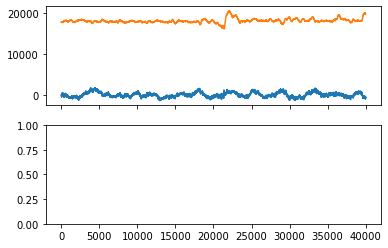

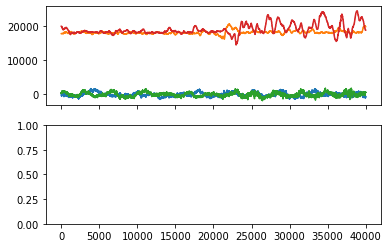

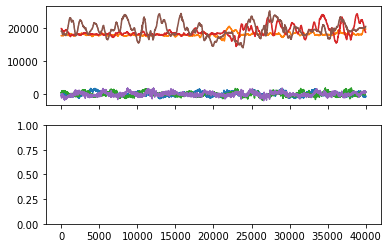

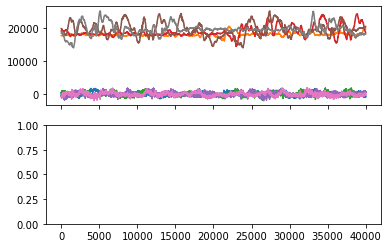

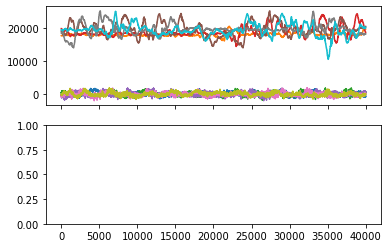

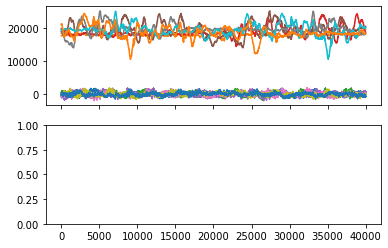

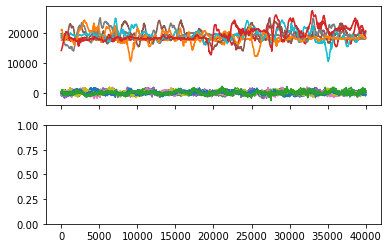

In [6]:
fig ,ax = plt.subplots(2,1,True)

while True:
    data = np.memmap('amplifier.dat',np.int16,mode = 'r').reshape(-1,nChannels)
    plt.sca(ax[0])
    plt.plot(data[-2*20_000:,[1,34]])
    plt.draw()
    plt.show()
    time.sleep(1)
    plt.clf()

In [119]:

import numpy as np
import matplotlib.pyplot as plt

import scipy.signal
from scipy.stats import zscore
from matplotlib.animation import FuncAnimation

import time

%matplotlib qt

fig, ax = plt.subplots(2,1)

lfp_line, = ax[0].plot([], [], 'green')
accel_line, = ax[0].plot([],[],'red')
spec_line, = ax[1].plot([],[])
peak_line = ax[1].axvline(0,color = 'red')
nChannels = 35




path = '/mnt/record-01/Billel/Rat50/Rat50-20211024/Rat50_211024_145248/'
os.chdir(path)


def init():
    ax[0].set_xlim(4, 5)
    ax[0].set_ylim(-8000,8000)
    ax[1].set_xlim(0,20)
    ax[1].set_ylim(0,75_000)
    return True


def update(frame):
    
    data = np.memmap('amplifier.dat',np.int16,mode = 'r').reshape(-1,nChannels)
    lfp = data[-5*20_000:,1]
    accel = data[-5*20_000:,34]

    xdata = np.arange(0,5*20000)/20_000

    f,sxx = scipy.signal.welch(lfp,fs = 20_000,nperseg=20000,noverlap=10000)
    max_f = f[np.argmax(sxx)]

    lfp_line.set_data(xdata, lfp-np.mean(lfp)+2000)
    accel_line.set_data(xdata,accel-np.mean(accel)-2000)
    spec_line.set_data(f,sxx)
    peak_line.set_data([max_f]*5,np.linspace(0,75_000,5))

    return True

ani = FuncAnimation(fig, update, frames=True,
                    init_func=init)
plt.show()

In [66]:
import time

In [89]:
f

NameError: name 'f' is not defined

In [106]:
[0]*5

[0, 0, 0, 0, 0]

In [111]:
np.arange(0,50000,5000).shape

(10,)

In [1]:
import bk.load
import bk.compute
import bk.plot

import matplotlib.pyplot as plt
import scipy.signal

%matplotlib qt

In [2]:
bk.load.current_session_linux('/media/billel/DATA/BK-DATA/','Rat50/Rat50-20211024')

Rat : 50 on day : 1
Working with session Rat50-20211024 @ /media/billel/DATA/BK-DATA/Rat50/Rat50-20211024


True

In [3]:
lfp = bk.load.lfp(1)
accel = bk.load.lfp(34)

In [4]:
digitalin = bk.load.digitalin().T

In [5]:
stim = digitalin[:,4]

In [6]:
stim_intervals = bk.compute.tone_intervals(stim)

In [7]:
stim_intervals.as_units('s')

,start,end
0,499.44270,505.39190
1,979.98705,987.45075
2,1058.50845,1236.20280


In [8]:
fig,ax = plt.subplots(3,1,True)
plt.sca(ax[0])
ax[0].plot(lfp.as_units('s'))
bk.plot.intervals(stim_intervals)
ax[1].plot(accel.as_units('s'))

f,t,sxx = scipy.signal.spectrogram(lfp.values,1250,nperseg=5000,noverlap=2500)
ax[2].pcolor(t,f,sxx,shading = 'gourault')
ax[2].set_ylim(0,20)

/tmp/ipykernel_65462/2387561777.py:1: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig,ax = plt.subplots(3,1,True)
/tmp/ipykernel_65462/2387561777.py:8: UserWarning: shading value 'gourault' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  ax[2].pcolor(t,f,sxx,shading = 'gourault')


(0.0, 20.0)

In [18]:
lfp.as_units('s')

Time (s)
0.0000     0
0.0008     0
0.0016     0
0.0024     0
0.0032     0
          ..
36.6024    0
36.6032    0
36.6040    0
36.6048    0
36.6056    0
Length: 45758, dtype: int16

In [9]:
import matplotlib.pyplot as plt

In [15]:
a = plt.bar([0,1],[5,10])

In [16]:
f = [1,2,3,4,5,6,7,8,9,10]

<BarContainer object of 2 artists>

In [24]:
((f>5) *(f<10))

array([False, False, False, ..., False, False, False])

In [ ]:
scipy.signal.spectrogram()

In [44]:
import numpy as np
import bk.load

from scipy.stats import cumfreq

In [29]:
bk.load.current_session_linux()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


True

In [30]:
rip = bk.load.ripples()

In [31]:
rip = rip['peak'].as_units('s')

In [33]:
rip = rip.index

In [36]:
rip = rip.values

In [53]:
t = np.arange(0,len(rip))
plt.plot(rip,t)

In [64]:
a = cumfreq(rip,21800)

In [65]:
plt.plot(a.cumcount)

In [49]:
a

CumfreqResult(cumcount=array([ 530., 1503., 2218., 2985., 2985., 2985., 3423., 4569., 5426.,
       5808.]), lowerlimit=316.2244444444443, binsize=2265.792711111111, extrapoints=0)

In [68]:
plt.plot(rip,t)
plt.plot(a.cumcount)

In [57]:
rip[-1]

21841.2552

In [69]:
t

array([   0,    1,    2, ..., 5805, 5806, 5807])

In [126]:
class Employee:
    def __init__(self,name,age,level,salary):
        self.name = name
        self.age = age
        self.level = level
        self._salary = salary

        self.is_working = False

    def work(self):
        if not self.is_working:
            self.is_working = True
            print(f'{self.name} is set to work')
        else:
            print(f'{self.name} is already working')
    
class Designer(Employee):
    pass 

class SoftwareEngineer(Employee):
    pass

In [127]:
se1 = SoftwareEngineer('Bill',18,1,75000)
se2 = SoftwareEngineer('Yas',18,1,75000)

de1 = Designer('Yaka',17,0,700)

In [130]:
se1._salary

500

In [125]:
se1.work()

Bill is already working


In [112]:
de1.resume()

Yaka
17


In [95]:
se1 == se2

5

In [96]:
se1.resume()

Bill
18


In [81]:
se1 == se2

True